# Data Analysis
Analyze the (hypothetical) training dataset (logistics.zip) provided to you, and report THREE significant findings that you believe will impact the model or system's performance.

## 1. Class Imbalances
One aspect of the training data that may impact the model's performance is the imbalance of detected object classes in the training set. By reading all of label files in the training set and keep track of the detected object in each file, I was able to find how many of each object was detected in the training set and plot the results in a bar chart below. The classes are very imbalanced, with the most commonly detected class being wood pallet with 9330 detections, and the least commonly detected class being gloves with 256 detections in the training set. The number of detections for the remaining object classes vary greatly between this range. This imbalance could lead to overfitting of the majority classes, and poor training of the model on minority classes.One way this may be decreased is by retraining the model after using hard negative mining to determine for what inputs the model performs the worst. If the model performs poorly on data with objects from the minority classes, then this will allow the model to be retrained using those data points, and hopefully perform better detecting objects in the minority classes. Additionally, when determining model performance using a metric such as average precision, the result will be dominated by the average precision for the majority classes. Instead, a better metric to use in this case of imbalanced classes is mean average precision (mAP) so the result isn't biased towards any majority classes.

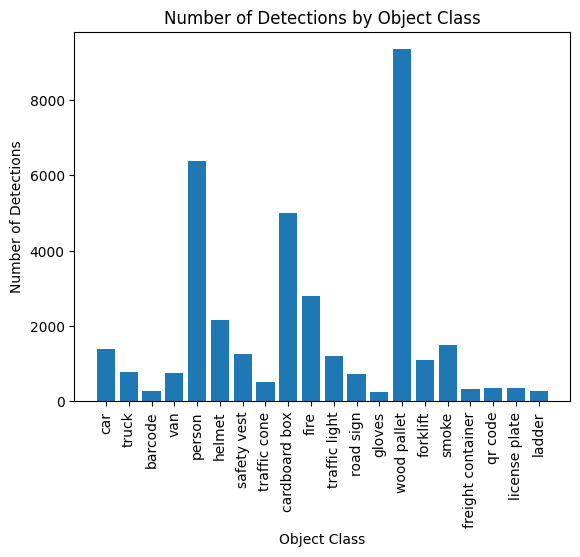

In [91]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Load class names from file
with open('../logistics/_darknet.labels', 'r') as f:
    classNames = [line.strip() for line in f.readlines()]

# Load training label files
trainImgLabels = [f'../logistics/{f}' for f in os.listdir('../logistics') if f[-4:] == '.txt']

# Find how many objects of each class are among the training label detections
classCounts = {}
for file in trainImgLabels:
    # Read label file and get detection classes
    with open(file, "r") as objs:
        lines = objs.readlines()
        classes = [row.split(' ')[0] for row in lines]
    # Increment counter for each class
    for c in classes:
        className = classNames[int(c)]
        classCounts[className] = classCounts.get(className,0) + 1
# Plot bar chart of number of detections by class
plt.bar(classCounts.keys(), classCounts.values())
plt.xticks(rotation=90)
plt.title('Number of Detections by Object Class')
plt.xlabel('Object Class')
plt.ylabel('Number of Detections')
plt.show()

## 2. Number of Objects Per Image
Another aspect of the training set that may affect model performance is the number of objects per image. As seen in the example images below, the number of objects in each image can vary graetly, even for the same object type. For example, one image below is of one cone, but another is of 18 cones close together. Additionally, one image shows one wood pallet, while another shows 4 and another shows 187 wood pallets. By reading all of label files in the training set and keep track of the number of detected objects in each file, I was able to find how many objects were detected in each image in the training set and plot the results in a histogram below. Many of the images (9307) had an object count that fell into the first hsitogram bin (1-23). Since this bin dominated the historgram, I plotted a second histogram below that has the same information, but does not have the first bin plotted, so that it's easier to see the distribution of the remaning 218 images. Most fell within the next bin (23-45), with only 56 of the 9525 total training images having more than 45 objects detected.

This means that the model needs to learn to detect objects that are close together, as well as objects of different sizes in the image. Images with a small number of objects likely have larger objects, while images with many objects likely have smaller objects. Carefully choosing an image size will help to ensure small objects can still be detected. If the image size is too small, then the resolution will not be good enough so smaller objects may not be detectable. The IOU threshold used in non-maximal supression will also have to carefully be chosen to ensure that objects that are close together do not get overlooked, will larger objects that are more spaced out do not get double counted.

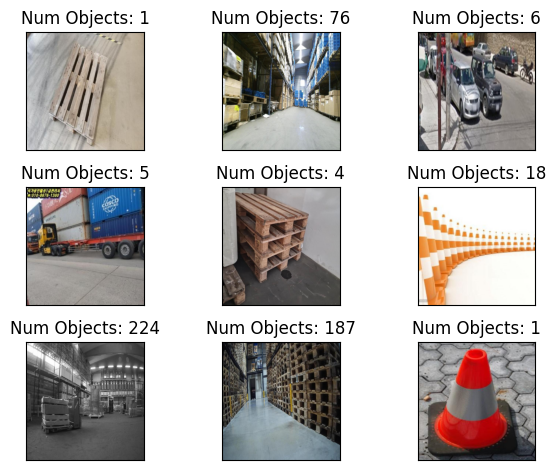

In [92]:
# Filenames of example images
images = ['00330_jpg.rf.533364ac2ce1412c5f78feb1c2271b15.jpg',
          '509660976-8698_jpg.rf.6851f5e9885ee29a48bd580c62de68a8.jpg',
          '-64FEA10C-1F32-4982-91EE-6FCD11A89A15-png_jpg.rf.97b766ac170c350f873f5470ee73c1ad.jpg',
          '-481_jpg.rf.5e8181b7a6dc256f61ac4330277c7a83.jpg',
          '0000268_jpg.rf.43752d8ae7317360a71c45cad37dcee1.jpg',
          '324_jpg.rf.de23062bd61726cd82ad62717bf9ad40.jpg',
          '1574675826-0214434_jpg.rf.f3f2bd95c46c90b410175f69373a72a1.jpg',
          '1579164086-6736007_jpg.rf.13557834ef2744cd0c5def3046cc5fe0.jpg',
          '304_jpg.rf.960a28cdf9cab9e73d5aa1bb60e080a1.jpg']
# Display example images with the number of objects in the image
for i in range(len(images)):
    # Read in image file
    img = plt.imread(f'../logistics/{images[i]}')
    # Read corresponding label file to find number of objects in detected in the image
    labelFile = f'../logistics/{images[i][:-4]}.txt'
    with open(labelFile, "r") as objs:
        lines = objs.readlines()
    # Plot the image
    plt.subplot(331+i)
    plt.title(f'Num Objects: {len(lines)}')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.imshow(img)

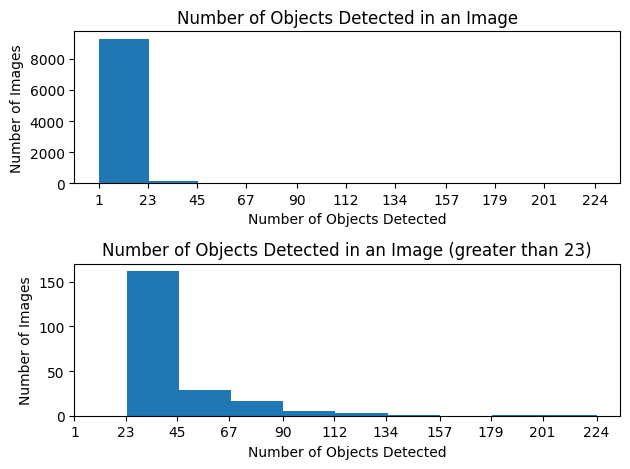

In [93]:
# Read training label files to find the number of objects in each training image
objectCounts = []
for file in trainImgLabels:
    with open(file, "r") as objs:
        lines = objs.readlines()
        objectCounts.append(len(lines))

# Plot histogram of number ojbects per image
fig, axs = plt.subplots(2,1)

# Histogram of all counts
counts, bins = np.histogram(objectCounts)
axs[0].hist(bins[:-1], bins, weights=counts)
axs[0].set_title(f'Number of Objects Detected in an Image')
axs[0].set_xlabel('Number of Objects Detected')
axs[0].set_ylabel('Number of Images')
axs[0].set_xticks([np.floor(b) for b in bins])

# Histogram of all counts greater than 23 (exclude first bin since it's so big)
axs[1].hist(bins[1:-1], bins[1:], weights=counts[1:])
axs[1].set_title(f'Number of Objects Detected in an Image (greater than 23)')
axs[1].set_xlabel('Number of Objects Detected')
axs[1].set_ylabel('Number of Images')
axs[1].set_xticks([np.floor(b) for b in bins])

fig.tight_layout()
plt.show()

## 3. Image Quality & Orientation
A third aspect of the training set that may affect the system's performance is the differences in image quality and orientation. Some images seem to have good quality and resolution, while others are blurred or noisy. Additionally, some images are rotated or are in black and white instead of color. The example images below show some ways in which the image qualities and orientations differ among the training images. For example in the plot below, Img1 and Img2 are blurry, Img 3 and Img5 have noise, and Img 4 and Img6 seem to be of fairly good quality. Img 7, 8, and 9 are all rotated, and Img8 is in black and white. This diversity in image quality may result in slightly lower training performance than if there were no diversity, but will help reduce overfitting and lead to a more robust and generalizable model that will likely perform better in production on unseen data.

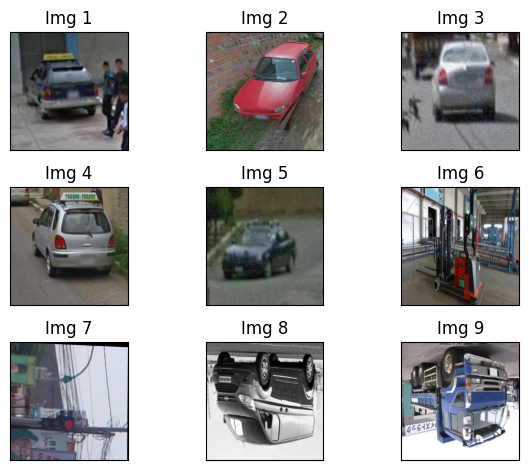

In [94]:
# Filenames of example images
images = ['-6EDBF25D-DB21-48EE-85C6-D053CD8F2E69-png_jpg.rf.5bf080145843760fa8521ff12acfdd60.jpg',
          '-8D8C45A6-6F74-4EE8-8B27-92EF359C677A-png_jpg.rf.305ab0b9873fca6ea9eaa111cbc116b9.jpg',
          '-9F9F0E6A-CA31-49AA-BBA6-15712933D355-png_jpg.rf.b734118f73e17d68eb791a10d6e4fea4.jpg',
          '-32B57B8F-DFE6-46BE-861C-1A9848452803-png_jpg.rf.a1c617d6dcbaaaa97d8fa4ca43dc6887.jpg',
          '-98A01F02-3CDB-4F80-B347-F645B271B2FD-png_jpg.rf.0fb5fb3f2208a1266acbdc36ef0cd322.jpg',
          'video13_14190_jpg.rf.bdc0977342931b2a0d07e5ed7f556088.jpg',
          'traffic-light-786-_jpg.rf.c533e9ccaa8f463ab6f8542f73371d08.jpg',
          'Van71_jpg.rf.3d49f9755a7080bd5c7b6da6359bfa17.jpg',
          'YT00640_1_jpg.rf.315ff11853e3d726114fdc3686691097.jpg']
# Display example images
for i in range(len(images)):
    # Read in image file
    img = plt.imread(f'../logistics/{images[i]}')
    # Plot image
    plt.subplot(331+i)
    plt.xticks([])
    plt.yticks([])
    plt.title(f'Img {i+1}')
    plt.tight_layout()
    plt.imshow(img)